# Streaming in LangGraph

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o')
llm.invoke('hello')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0HR8L7nTrk6l8LEVsAZCSMQvO2u6', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a7a0cd47-0459-47b4-81b0-e299649f2cdf-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langchain_groq import ChatGroq
llm_groq = ChatGroq(model = 'qwen/qwen3-32b')
llm_groq.invoke('hello')

AIMessage(content='<think>\nOkay, the user just said "hello". I need to respond appropriately. Let me start by acknowledging their greeting. Maybe add a friendly emoji to keep it warm. I should ask how I can assist them today to open the conversation. Keep it simple and welcoming. Let me make sure the tone is positive and helpful.\n</think>\n\nHello! 😊 How can I assist you today? Let me know if you have any questions or need help with something specific!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 95, 'prompt_tokens': 9, 'total_tokens': 104, 'completion_time': 0.160264732, 'prompt_time': 0.006137358, 'queue_time': 0.193874208, 'total_time': 0.16640209}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--7a7f7e99-91ef-44c2-89c5-77e3c04f52c1-0', usage_metadata={'input_tokens': 9, 'output_tokens': 95, 'total_tokens': 104})

# Creating nodes

In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
def superbot(state: State):
    return {'messages': [llm_groq.invoke(state['messages'])]}

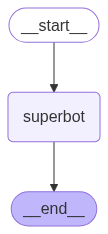

In [22]:
from IPython.display import Image, display 
graph = StateGraph(State)
graph.add_node('superbot', superbot)

## add edges
graph.add_edge(START, 'superbot')
graph.add_edge('superbot', END)

# compile graph
graph_builder = graph.compile()

# display
display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [23]:
## invocation
config = {'configurable': {'thread_id':'1'}}
graph_builder.invoke({'messages': 'Hello my name is abcd and I like cricket'},config)

{'messages': [HumanMessage(content='Hello my name is abcd and I like cricket', additional_kwargs={}, response_metadata={}, id='a83a3b75-0ed9-426b-b751-c12507a4a882'),
  AIMessage(content='<think>\nOkay, the user introduced themselves as "abcd" and mentioned they like cricket. First, I need to respond in a friendly and welcoming manner. Since the name is "abcd," maybe they used a placeholder or just want to keep their name anonymous. I should acknowledge their introduction and express enthusiasm about their interest in cricket.\n\nI should ask a follow-up question to encourage them to share more about why they like cricket or how they got into it. Maybe something like, "That\'s great! What made you start following cricket, or do you play it as well?" That way, it opens the door for a more detailed conversation.\n\nI also need to make sure the tone is positive and supportive. Avoid any assumptions about why they chose "abcd" as a name. Keep the focus on their interest in cricket. Maybe m

## Streaming responses with stream()
- stream_mode = 'updates': streams the latest state of graph
- stream_mode = 'values: streams the full state of graph (all convos)

In [ ]:
# create a thread
config = {'configurable': {'thread_id':'2'}}
for chunk in graph_builder.stream({'messages': 'Hello my name is abcd and I like cricket'}, config=config, stream_mode='updates'):
    print(chunk)
    


KeyError: 'messages'

In [ ]:
# create a thread
for chunk in graph_builder.stream({'messages': 'Hello my name is abcd and I like cricket'},config, stream_mode='values'):
    print(chunk)

{'messages': [HumanMessage(content='Hello my name is abcd and I like cricket', additional_kwargs={}, response_metadata={}, id='a9806371-7e93-4cf1-8e3c-6a233f4218f5')]}
{'messages': [HumanMessage(content='Hello my name is abcd and I like cricket', additional_kwargs={}, response_metadata={}, id='a9806371-7e93-4cf1-8e3c-6a233f4218f5'), AIMessage(content='<think>\nOkay, the user introduced themselves as "abcd" and mentioned they like cricket. I need to respond in a friendly and engaging way. First, I should acknowledge their name and interest. Since "abcd" is a username or a placeholder, maybe they\'re using it for privacy, so I should respect that. I should ask them about their favorite cricket teams or players to keep the conversation going. Also, maybe ask if they follow any particular leagues like the IPL or Test series. I need to make sure the questions are open-ended to encourage them to share more. Let me check if there\'s any recent cricket news I can mention to be relevant, but ma

In [ ]:
# create a thread
for chunk in graph_builder.stream({'messages': 'I love football too!'}, config, stream_mode='updates'):
    print(chunk)
    


{'superbot': {'messages': [AIMessage(content='<think>\nOkay, the user says "I love football too!" which is a positive and enthusiastic response. Since they share this common interest, I should acknowledge their enthusiasm. I can ask follow-up questions to keep the conversation flowing. Maybe ask which team they support or their favorite players. But I need to be careful not to assume too much about their preferences. Also, I should maintain a friendly and open tone to encourage them to share more. Let me make sure my response is welcoming and shows genuine interest in their football passion.\n</think>\n\nThat\'s awesome! Football is such an exciting sport with so much passion and energy. Do you follow any particular teams or players? I\'d love to hear about your favorite moments or what you enjoy most about the game! ⚽😄', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 13, 'total_tokens': 170, 'completion_time': 0.55807357, 'prompt_ti

In [ ]:
# create a thread
for chunk in graph_builder.stream({'messages': 'I love swimming too'},config, stream_mode='values'):


{'messages': [HumanMessage(content='I love swimming too', additional_kwargs={}, response_metadata={}, id='228d2075-d5ff-4ccb-a6c7-cbddfe2e5875')]}
{'messages': [HumanMessage(content='I love swimming too', additional_kwargs={}, response_metadata={}, id='228d2075-d5ff-4ccb-a6c7-cbddfe2e5875'), AIMessage(content="<think>\nOkay, the user mentioned they love swimming too. Let me think about how to respond. First, I should acknowledge their shared interest. Maybe ask about what they enjoy most about swimming. Do they prefer different strokes? Maybe they compete or just swim for fun? Also, maybe they have a favorite place to swim. I should keep the conversation open-ended so they can elaborate. I should also mention my own experience if I have any, but since I'm an AI, I can't swim. Hmm, how to phrase that. Maybe talk about the benefits of swimming or share some interesting facts. Let me check for any cultural references or common swimming terms. Maybe ask if they have any swimming goals or a